## Exercise-08
## Index No - 190621M
## Name - K. Thanushan

### Question 1. and 2.

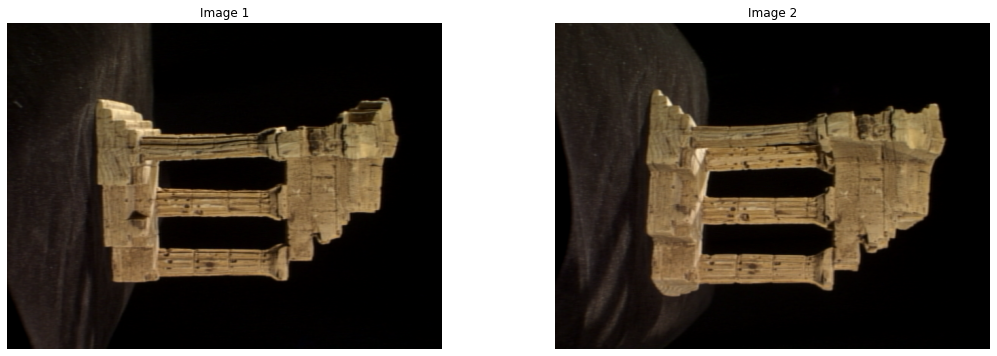

F=  [[-2.87071497e-04 -3.96261289e-02  2.94221686e+02]
 [-3.55039713e-02  1.65329260e-04  1.78860854e+01]
 [-2.76702814e+02  2.12942175e+01 -9.06669374e+03]]


In [8]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from scipy.linalg import null_space
def skew(x):
    x = x.ravel()
    return np.array([[0, -x[2], x[1]], [x[2], 0, -x[0]], [-x[1], x[0], 0]])

f = open(r'./templeSparseRing/templeSR_par.txt', 'r')
assert f is not None
n = int(f.readline())

# Reading the information on the first image
l = f.readline().split()
im1_fn = l[0]
K1 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R1 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t1 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

# Reading the information on the second image
l = f.readline().split()
im2_fn = l[0]
K2 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R2 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t2 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

#Read the two images and show
im1 = cv.imread(r'./templeSparseRing/' + im1_fn, cv.IMREAD_COLOR)
im2 = cv.imread(r'./templeSparseRing/' + im2_fn, cv.IMREAD_COLOR)
assert im1 is not None
assert im2 is not None
fig, ax = plt.subplots(1,2, figsize = (18,6))
Imageplot = cv.cvtColor(im1, cv.COLOR_BGR2RGB)
ax[0].imshow(Imageplot)
ax[0].set_title('Image 1')
ax[0].axis('off')
Imageplot2 = cv.cvtColor(im2, cv.COLOR_BGR2RGB)
ax[1].imshow(Imageplot2)
ax[1].set_title('Image 2')
ax[1].axis('off')
plt.show()

#Compute P1 and P2
P1 = K1@np.hstack((R1, t1)) #P = K*[R|t]
P2 = K1@np.hstack((R2, t2)) #P = K*[R|t]

#Compute F
c = null_space(P1)
c = c*np.sign(c[0,0])
e2 = P2@c
e2x = skew(e2)
F = e2x@P2@np.linalg.pinv(P1)
print('F= ', F)

#Compute epipolar line corresponding to the given x and plot


### Question 3

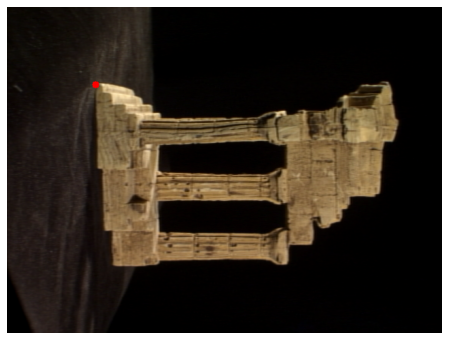

In [9]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
x = np.array([130, 115, 1])
cv.circle(im1, (x[0], x[1]), 5, (0,0,255), -1)
Imageplot = cv.cvtColor(im1, cv.COLOR_BGR2RGB)
fig, ax = plt.subplots(1, 1, figsize  = (18,6))
ax.imshow(Imageplot)
ax.axis('off')
plt.show()

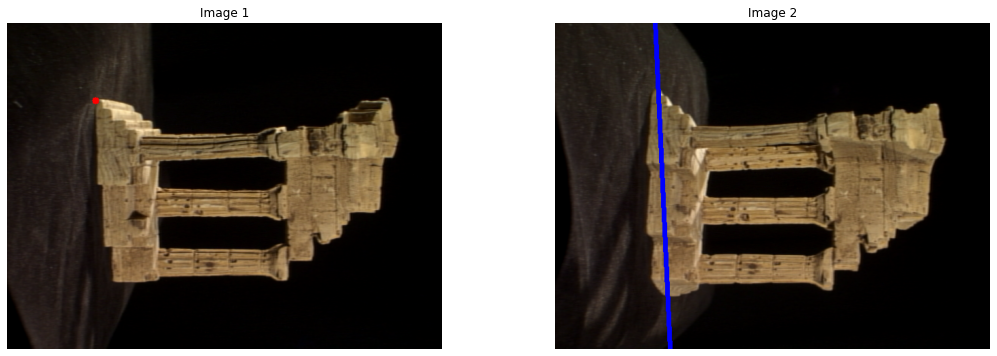

In [10]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
l2 = F@x.T
p1 = np.array([0,(l2[0]*0 + l2[2])/l2[1]]).astype(int)
p2 = np.array([500,(l2[0]*500 + l2[2])/l2[1]]).astype(int)
cv.line(im2, (p1[0], p1[1]), (p2[0], p2[1]), (255,0,0), 5)
fig, ax = plt.subplots(1,2, figsize = (18,6))
Imageplot = cv.cvtColor(im1, cv.COLOR_BGR2RGB)
ax[0].imshow(Imageplot)
ax[0].set_title('Image 1')
ax[0].axis('off')
Imageplot2 = cv.cvtColor(im2, cv.COLOR_BGR2RGB)
ax[1].imshow(Imageplot2)
ax[1].set_title('Image 2')
ax[1].axis('off')
plt.show()


### Question 4.

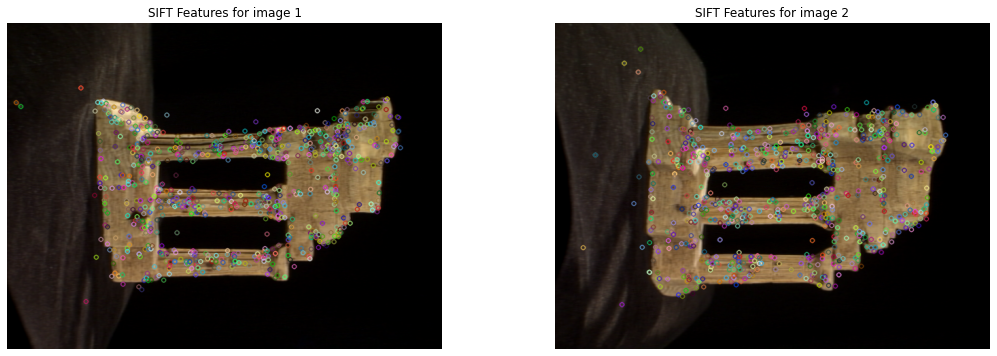

In [46]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

im1 = cv.imread(r'./templeSparseRing/' + im1_fn, cv.IMREAD_COLOR)
im2 = cv.imread(r'./templeSparseRing/' + im2_fn, cv.IMREAD_COLOR)
assert im1 is not None
assert im2 is not None

sift = cv.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(im1, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(im2, None)

sift_image1 = cv.drawKeypoints(im1, keypoints_1, im1)
sift_image2 = cv.drawKeypoints(im2, keypoints_2, im2)

fig, ax = plt.subplots(1,2, figsize = (18,6))
Imageplot1 = cv.cvtColor(sift_image1, cv.COLOR_BGR2RGB)
ax[0].imshow(Imageplot1)
ax[0].set_title('SIFT Features for image 1')
ax[0].axis('off')
Imageplot2 = cv.cvtColor(sift_image2, cv.COLOR_BGR2RGB)
ax[1].imshow(Imageplot2)
ax[1].set_title('SIFT Features for image 2')
ax[1].axis('off')
plt.show()


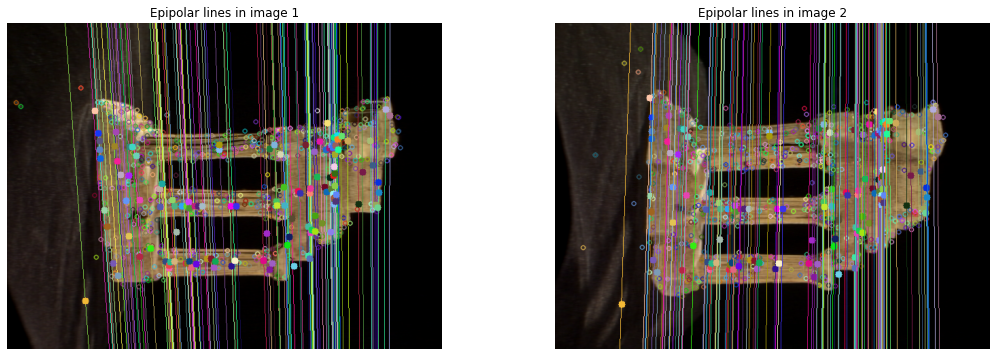

In [47]:

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(descriptors_1, descriptors_2,k=2)

points1 = []
points2 = []


for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        points1.append(keypoints_1[m.queryIdx].pt)
        points2.append(keypoints_2[m.trainIdx].pt)

points1 = np.int32(points1)
points2 = np.int32(points2)
F, mask = cv.findFundamentalMat(points1,points2,cv.FM_LMEDS)

# We select only inlier points
points1 = points1[mask.ravel()==1]
points2 = points2[mask.ravel()==1]

def drawlines(img1,img2,lines,points1,points2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape[0], img1.shape[1]
    for r,point1,point2 in zip(lines,points1,points2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1]])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(point1),5,color,-1)
        img2 = cv.circle(img2,tuple(point2),5,color,-1)
    return img1,img2

lines1 = cv.computeCorrespondEpilines(points2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(im1,im2,lines1,points1,points2)

lines2 = cv.computeCorrespondEpilines(points1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(im2,im1,lines2,points2,points1)

fig, ax = plt.subplots(1,2, figsize = (18,6))
Imageplot1 = cv.cvtColor(img5, cv.COLOR_BGR2RGB)
ax[0].imshow(Imageplot1)
ax[0].set_title('Epipolar lines in image 1')
ax[0].axis('off')
Imageplot2 = cv.cvtColor(img3, cv.COLOR_BGR2RGB)
ax[1].imshow(Imageplot2)
ax[1].set_title('Epipolar lines in image 2')
ax[1].axis('off')
plt.show()